# There are three instructions in this notebook for data augmentation:
- 1) Applying transformations to a single image
- 2) With a custom DataMapper
- 3) Changine the config file


In [ ]:
from PIL import Image
import xml.etree.ElementTree as ET
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import imageio

In [ ]:
# Mount your Google Drive (Need the Pascal VOC dataset in your Drive)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Install Detectron2

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


In [ ]:
# Install other dependencies

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# **1) Applying transformations to a single image**
- Getting an image and showing it.
- Parsing the image's annotation (xml) file.
- Extracting bounding boxes from the parsed annotation file.
- Applying some transformations on the image and its Bounding boxes.
- Displaying the transformed image with its bounding boxes.

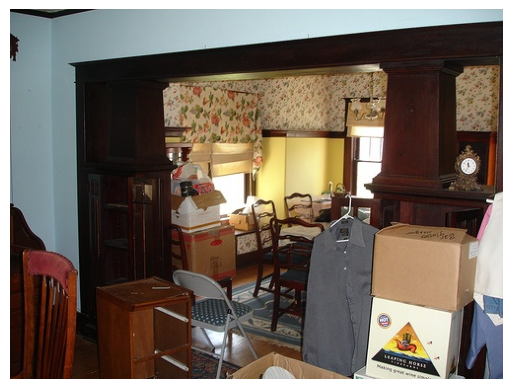

In [ ]:
# Showing an image (The one that its xml file will be used for further actions)

from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET

# Read image using matplotlib
image = plt.imread('/content/drive/MyDrive/Pascal-VOC-2007-TrainVal/VOCdevkit/VOC2007/JPEGImages/000005.jpg') 

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off') # Turn off axis
plt.show()


In [ ]:
# Parse an XML file
tree = ET.parse('/content/drive/MyDrive/Pascal-VOC-2007-TrainVal/VOCdevkit/VOC2007/Annotations/000005.xml')  
root = tree.getroot()


In [ ]:
# Extracting the list of bounding boxes from the xml file (It'll be used for "AugInput")

import re
from sklearn.preprocessing import OneHotEncoder
from detectron2.structures import BoxMode

def getting_bboxes(tree):

    bboxes = []
    s = 0

    for filename in os.listdir(tree):
      xml_filepath = os.path.join(tree, filename)
      dataset = ET.parse(xml_filepath)

      for element in dataset.iter():
        if element.tag == 'object':
          for subelement in element:
            if subelement.tag == "bndbox":
              for subelement2 in subelement:
                if subelement2.tag == 'xmin':
                  bboxes.append([])
                bboxes[s].append(float(subelement2.text))
                if subelement2.tag == 'ymax':
                  s += 1

    return bboxes


In [ ]:
boxes = getting_bboxes('/content/test/annotation')
boxes

[[263.0, 211.0, 324.0, 339.0],
 [165.0, 264.0, 253.0, 372.0],
 [5.0, 244.0, 67.0, 374.0],
 [241.0, 194.0, 295.0, 299.0],
 [277.0, 186.0, 312.0, 220.0]]

In [ ]:
# Data transformation (For augmentation) on a single image

from detectron2.data import transforms as T

# The list of transformations
augs = T.AugmentationList([
    T.RandomBrightness(0.8, 1.8),
    T.Resize((300, 300)),
    T.RandomContrast(0.6, 1.3),
    T.RandomSaturation(0.8, 1.4),
    T.RandomRotation(angle=[90, 90]),
    T.RandomLighting(0.7),
    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
])

# Passing the input image and its bboxes
input = T.AugInput(image, boxes=boxes)

# Applying the transformations to the specified input
transform = augs(input)

# Getting the transformed image and its bboxes
image_transformed = input.image
boxes_transformed = input.boxes


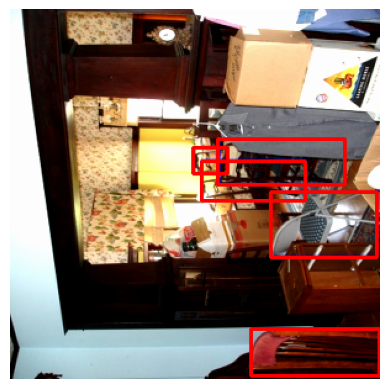

In [ ]:
# Displaying the transformed image with its bboxes

import matplotlib.pyplot as plt

# Draw bounding boxes on the image array
for bbox in boxes_transformed:
    xmin, ymin, xmax, ymax = bbox

    # Convert coordinates to integers
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    cv2.rectangle(image_transformed, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

# Display the image with its bounding boxes
image_transformed_RGB = cv2.cvtColor(image_transformed, cv2.COLOR_BGR2RGB)
plt.imshow(image_transformed_RGB)
plt.axis('off')
plt.show()


# **2) With a custom DataMapper**
- Creating a custom DataMapper.
- Applying the custom DataMapper.
- Continue with the dataset registeration and fine-tuning the model.

In [ ]:
# Creating a custom DataMapper

from detectron2.data import detection_utils as utils
import copy

def mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)

    # Reading image
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    # A list of transformations
    augs = T.AugmentationList([
        T.RandomBrightness(0.8, 1.8),
        T.Resize((300, 300)),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
    ])

    # Applying transformations to the image
    input = T.AugInput(image)
    transform = augs(input)
    image = torch.from_numpy(input.image.transpose(2, 0, 1))

    # Taking out the 'bounding boxes' from the annotations
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]

    return {
       # create the format that the model expects
       "image": image,
       "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }


In [ ]:
# Applying the new custom datamapper to "build_detection_train_loader"

from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)

# **3) Changine the config file**
- Prepare a list of transformation.
- Apply it to the config file.
- Continue the training procedure.

In [ ]:
# Register Pascal VOC dataset

from detectron2.data.datasets import register_pascal_voc

register_pascal_voc("Pascal_VOC_2007_train_val", "/content/drive/MyDrive/Pascal-VOC-2007-TrainVal/VOCdevkit/VOC2007", "trainval", 2007) # Don't forget to use your own path to the dataset
register_pascal_voc("Pascal_VOC_2007_test", "/content/drive/MyDrive/Pascal-VOC-2007-Test/VOCdevkit/VOC2007", "test", 2007) # Don't forget to use your own path to the dataset


In [ ]:
# Load catalogs with the dataset

from detectron2.data import DatasetCatalog
dataset_dicts = DatasetCatalog.get("Pascal_VOC_2007_train_val")

from detectron2.data import MetadataCatalog
dataset_metadata = MetadataCatalog.get("Pascal_VOC_2007_train_val")

In [ ]:
# Cloning Detectron2's repository to access models

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [ ]:
import json
from detectron2.structures import BoxMode
import itertools
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
from detectron2.data.transforms import AugmentationList, Resize, RandomFlip

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2_repo/configs/PascalVOC-Detection/faster_rcnn_R_50_C4.yaml")
cfg.DATASETS.TRAIN = ("Pascal_VOC_2007_train_val")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128



# Define a sequence of augmentations:
augs = T.AugmentationList([
        # T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
])
dataset_mapper = DatasetMapper(
    is_train=True,
    augmentations= [augs],
    image_format="RGB"
)

# Apply the changes to the configuration file
cfg.DATALOADER.AUGMENTATIONS = [("custom_mapper", dataset_mapper)]

# Training the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()